In [56]:
from src.network.customics import CustOMICS
from src.tools.prepare_dataset import prepare_dataset
from src.tools.utils import get_sub_omics_df, get_common_samples
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch

import os
import configparser


parser = configparser.ConfigParser()
parser.read('../Data/config.ini')
base_path = parser['autoencoder']['base_path']   


omics_df = {
            'gene_exp': pd.read_csv(os.path.join(base_path, 'TCGA-OV.htseq_fpkm-uq.tsv'), sep='\t', index_col=0, header=0).T,
            'methyl': pd.read_csv(os.path.join(base_path, 'TCGA-OV.methylation27.tsv'), sep='\t', index_col=0, header=0).T,
            'cnv': pd.read_csv(os.path.join(base_path, 'TCGA-OV.gistic.tsv'), sep='\t', index_col=0, header=0).T,
            }
clinical_df = pd.read_csv(os.path.join(base_path, 'TCGA-OV.survival_labeled.tsv'), sep='\t', index_col=0, header=0)



In [63]:
for name, omics in omics_df.items():
    omics.dropna(inplace=True, how='all', axis=1)
    omics.fillna(value=0, inplace=True)   
    print(omics.shape)

(379, 60483)
(613, 24981)
(620, 19729)


In [64]:
lt_samples = get_common_samples([*list(omics_df.values()), clinical_df])
print(f"n of sample: {len(lt_samples)}")

samples_train, samples_test = train_test_split(lt_samples, test_size=0.2)
samples_train, samples_val = train_test_split(samples_train, test_size=0.2)


omics_train = get_sub_omics_df(omics_df, samples_train)
omics_val = get_sub_omics_df(omics_df, samples_val)
omics_test = get_sub_omics_df(omics_df, samples_test)


x_dim = [omics_df[omic_source].shape[1] for omic_source in omics_df.keys()]


n of sample: 369


In [65]:
filtered_df = clinical_df.loc[lt_samples]
filtered_df[filtered_df['OS'] == 1]


,OS,_PATIENT,OS.time,OS.label
sample,,,,
TCGA-04-1655-01A,1,TCGA-04-1655,1380,0
TCGA-13-1485-01A,1,TCGA-13-1485,629,0
TCGA-04-1514-01A,1,TCGA-04-1514,1720,1
TCGA-25-1628-01A,1,TCGA-25-1628,627,0
TCGA-24-2026-01A,1,TCGA-24-2026,1059,0
...,...,...,...,...
TCGA-23-1021-01B,1,TCGA-23-1021,1446,0
TCGA-13-1511-01A,1,TCGA-13-1511,1650,1
TCGA-24-1928-01A,1,TCGA-24-1928,336,0


In [66]:
batch_size = 32
n_epochs = 20
device = torch.device('cpu')
label = 'OS.label'
event = 'OS'
surv_time = 'OS.time'

task = 'classification'
sources = omics_df.keys()

hidden_dim = [512, 256]
central_dim = [512, 256]
rep_dim = 256
latent_dim = 256
num_classes = 2
dropout = 0.45
beta = 1
lambda_classif = 5
classifier_dim = [128]
lambda_survival = 0
survival_dim = [256]

source_params = {}
central_params = {'hidden_dim': central_dim, 'latent_dim': latent_dim, 'norm': True, 'dropout': dropout, 'beta': beta}
classif_params = {'n_class': num_classes, 'lambda': lambda_classif, 'hidden_layers': classifier_dim, 'dropout': dropout}
surv_params = {'lambda': lambda_survival, 'dims': survival_dim, 'activation': 'SELU', 'l2_reg': 1e-3, 'norm': True, 'dropout': dropout}
for i, source in enumerate(sources):
    source_params[source] = {'input_dim': x_dim[i], 'hidden_dim': hidden_dim, 'latent_dim': rep_dim, 'norm': True, 'dropout': 0.2}
train_params = {'switch': 5, 'lr': 1e-3}


In [67]:
model = CustOMICS(source_params=source_params, central_params=central_params, classif_params=classif_params,
                        surv_params=surv_params, train_params=train_params, device=device).to(device)
print('Number of Parameters: ', model.get_number_parameters())

Number of Parameters:  83404265


In [68]:
model.fit(omics_train=omics_train, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
            omics_val=omics_val, batch_size=batch_size, n_epochs=n_epochs, verbose=True)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


	Epoch 1 complete! 	Average Loss Train :  3.9038628935813904 	Average Loss Val :  3.5938212871551514
	Epoch 2 complete! 	Average Loss Train :  3.4782447814941406 	Average Loss Val :  3.266886830329895
	Epoch 3 complete! 	Average Loss Train :  3.0834647119045258 	Average Loss Val :  3.052852749824524
	Epoch 4 complete! 	Average Loss Train :  2.6963510513305664 	Average Loss Val :  2.841654896736145
	Epoch 5 complete! 	Average Loss Train :  2.3417321741580963 	Average Loss Val :  2.5207360982894897
	Epoch 6 complete! 	Average Loss Train :  2.0085654109716415 	Average Loss Val :  2.0210938453674316
	Epoch 7 complete! 	Average Loss Train :  1.6742042005062103 	Average Loss Val :  1.8128654956817627
	Epoch 8 complete! 	Average Loss Train :  1.380123645067215 	Average Loss Val :  1.4413940906524658
	Epoch 9 complete! 	Average Loss Train :  1.141422837972641 	Average Loss Val :  1.3308883309364319
	Epoch 10 complete! 	Average Loss Train :  0.9423379972577095 	Average Loss Val :  1.19325113296

[{'Accuracy': 0.78125,
  'F1-score': 0.7260934819897086,
  'Precision': 0.8322916666666667,
  'Recall': 0.78125,
  'AUC': 0.5721618357487923}]

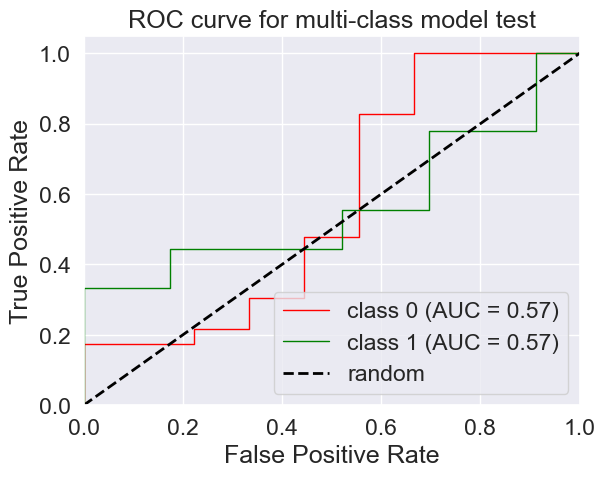

In [69]:
model.evaluate(omics_test=omics_test, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
                task=task, batch_size=32, plot_roc=True)

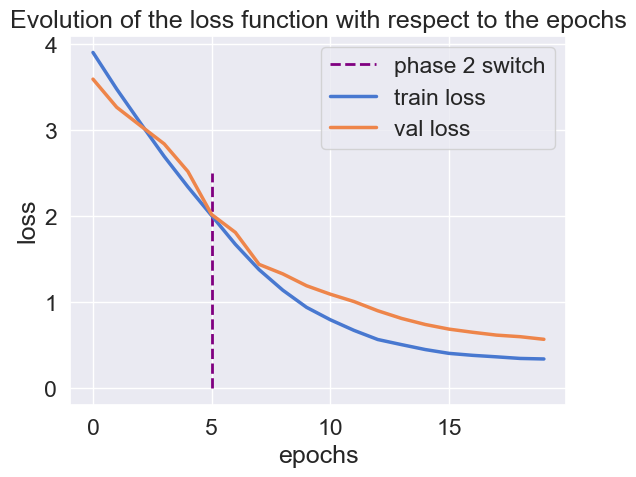

In [70]:
model.plot_loss()
